In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

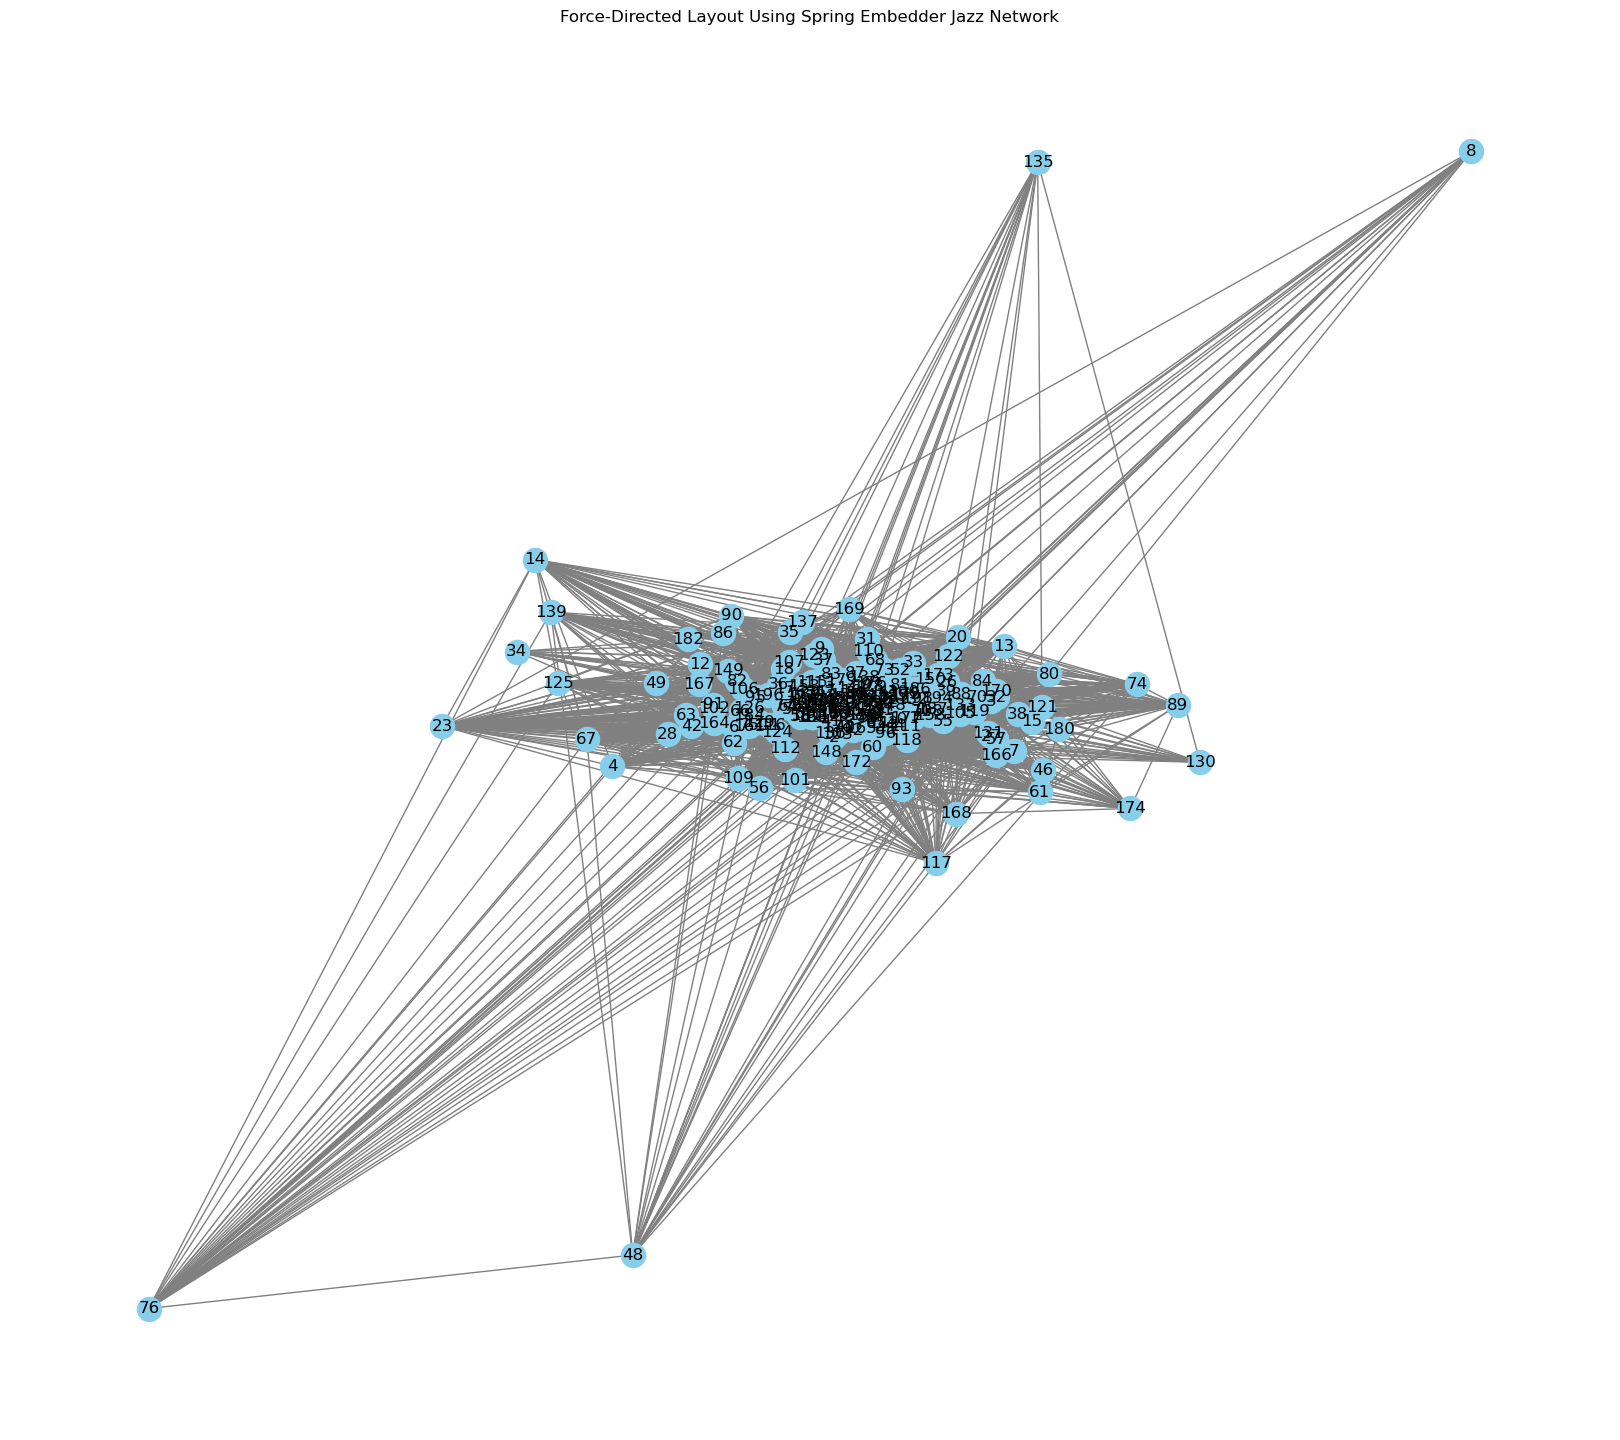

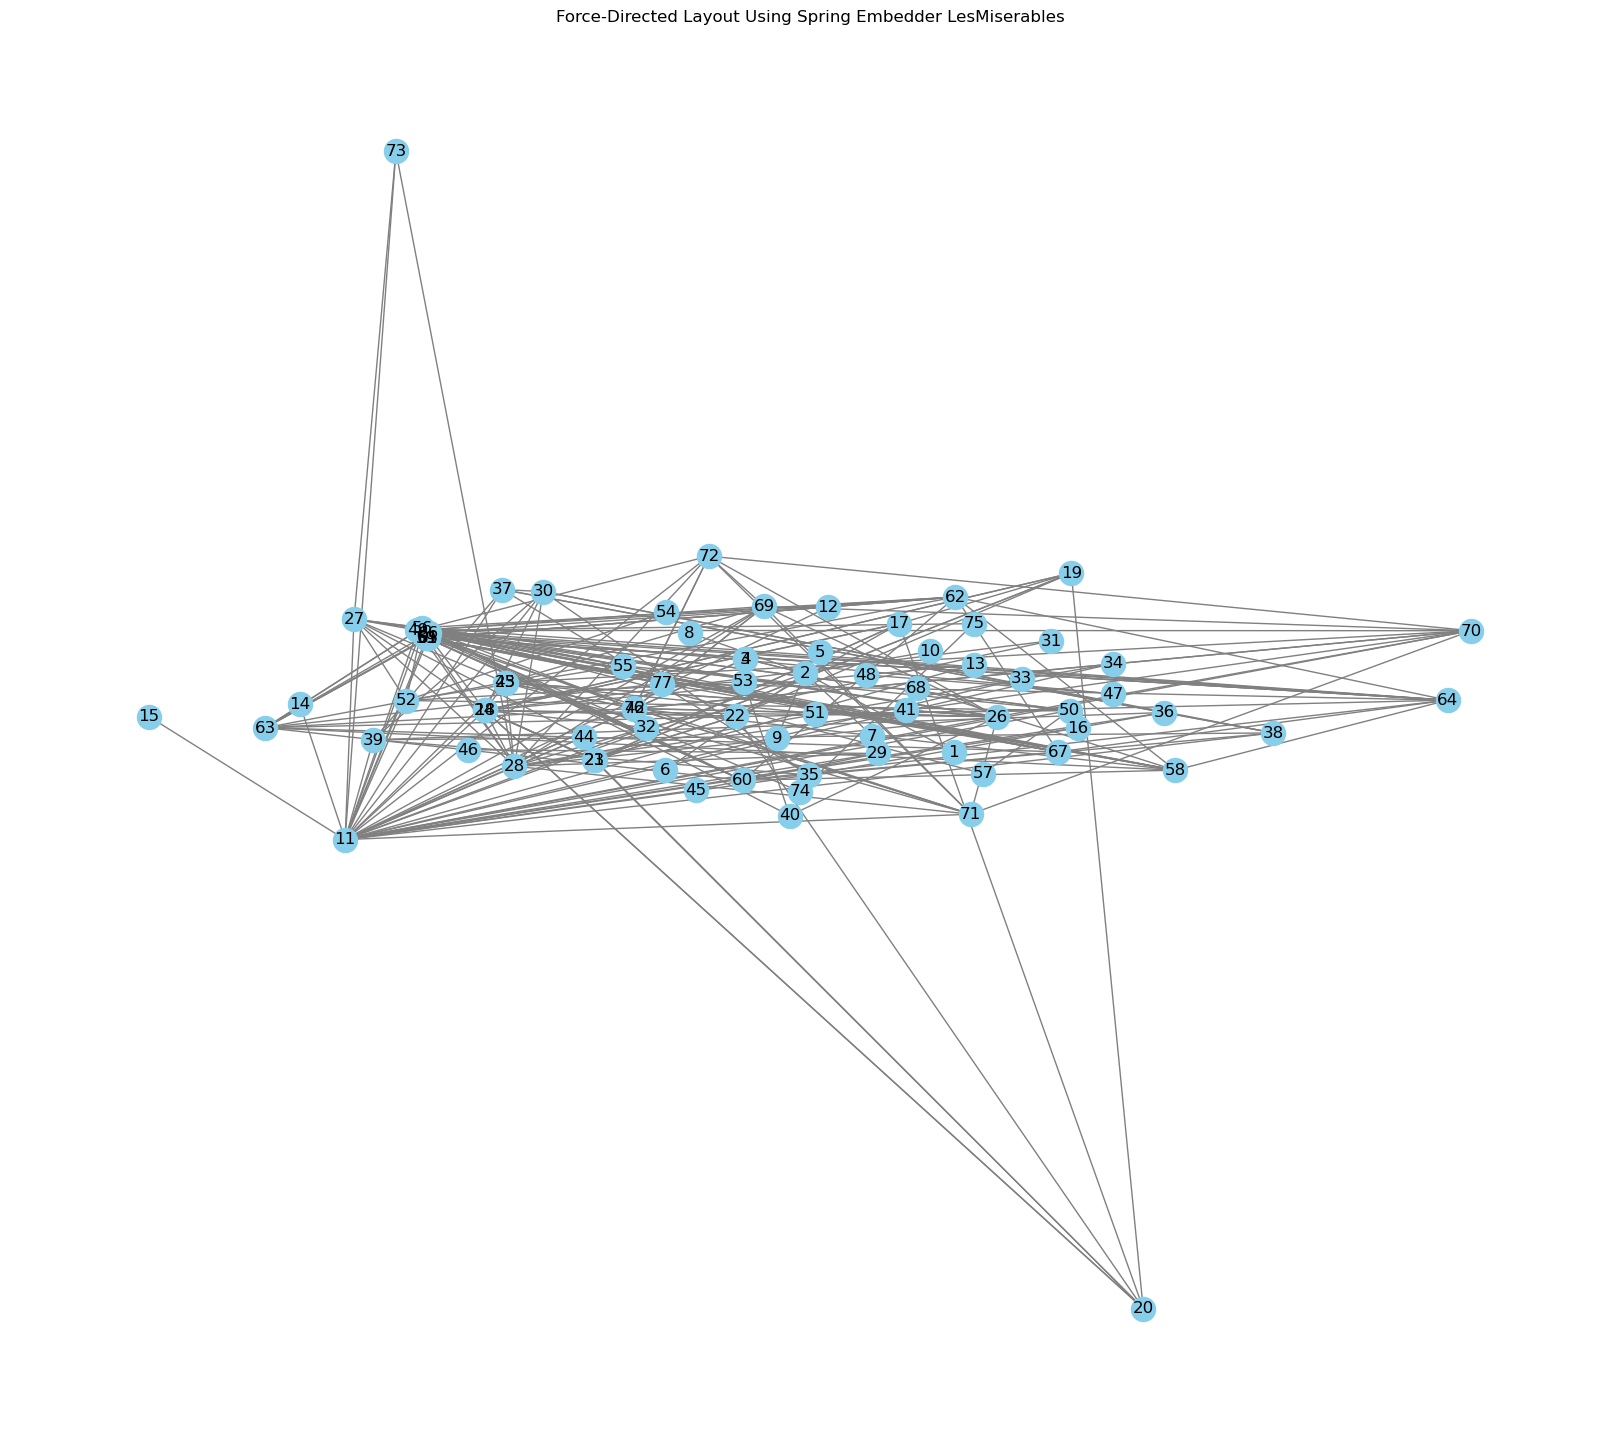

In [10]:
Graph = nx.nx_agraph.read_dot('./Dataset/JazzNetwork.dot/JazzNetwork.dot')
Graph_1=nx.nx_agraph.read_dot('./Dataset/LesMiserables.dot/LesMiserables.dot')


np.random.seed(42)  
initial_pos_scale = 1.0  
random_pos = {node: initial_pos_scale * np.random.rand(2) for node in Graph.nodes()} 

nx.set_node_attributes(Graph, random_pos, 'pos')
    
def repulsive_forces(G, k):  #k is C_rep
    forces = {node: np.array([0.0, 0.0]) for node in G.nodes()}
    for u in G.nodes():
        for v in G.nodes():
            if u != v and not G.has_edge(u, v):
                delta = np.array(G.nodes[u]['pos']) - np.array(G.nodes[v]['pos'])
                distance = np.linalg.norm(delta)
                if distance > 0:
                    repulsive_force = k / distance**2
                    forces[u] += repulsive_force * (delta / distance) #delta is normalized
    return forces


def spring_forces(G, k, optimal_length): #k is C_spring
    
    forces = {node: np.array([0.0, 0.0]) for node in G.nodes()}

    for u in G.nodes():
        for v in G.nodes():
            if G.has_edge(u, v):
                delta = np.array(G.nodes[u]['pos']) - np.array(G.nodes[v]['pos'])
                distance = np.linalg.norm(delta)
                if distance > 0:
                    spring_force_magnitude = k * np.log(distance / optimal_length)
                    spring_force = spring_force_magnitude * (delta / distance) 
                    forces[u] += spring_force
                    
    return forces

def spring_embedder(G, k_rep, k_spring, optimal_length, iterations, threshold, delta):
    
    for node in G.nodes():
        if 'pos' not in G.nodes[node]:
            G.nodes[node]['pos'] = np.random.rand(2)

    t = 1
    while t <= iterations:
        rep_forces = repulsive_forces(G, k_rep)
        spr_forces = spring_forces(G, k_spring, optimal_length)
        
        net_force = {node: np.array([0.0, 0.0]) for node in G.nodes()}  # Initialize net forces
        
        for node in G.nodes():
            net_force[node] = rep_forces[node] + spr_forces[node]

        for node in G.nodes():
            G.nodes[node]['pos'] += delta * net_force[node]
        
        max_force = max(np.linalg.norm(force) for force in net_force.values())
        if max_force < threshold:
            break
        
        t += 1
    
    return {node: G.nodes[node]['pos'] for node in G.nodes()}

position = spring_embedder(Graph, 1, 2, 1, 100, 1e-5, 0.001)


plt.figure(figsize=(16, 14))
nx.draw(Graph, position, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray')
plt.title('Force-Directed Layout Using Spring Embedder Jazz Network')
plt.show()


position_1 = spring_embedder(Graph_1, 1, 2, 1, 100, 1e-5, 0.001)

plt.figure(figsize=(16, 14))
nx.draw(Graph_1, position_1, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray')
plt.title('Force-Directed Layout Using Spring Embedder LesMiserables')
plt.show()

## pre-defined function only for the comparison to obatained layouts (not use it) 

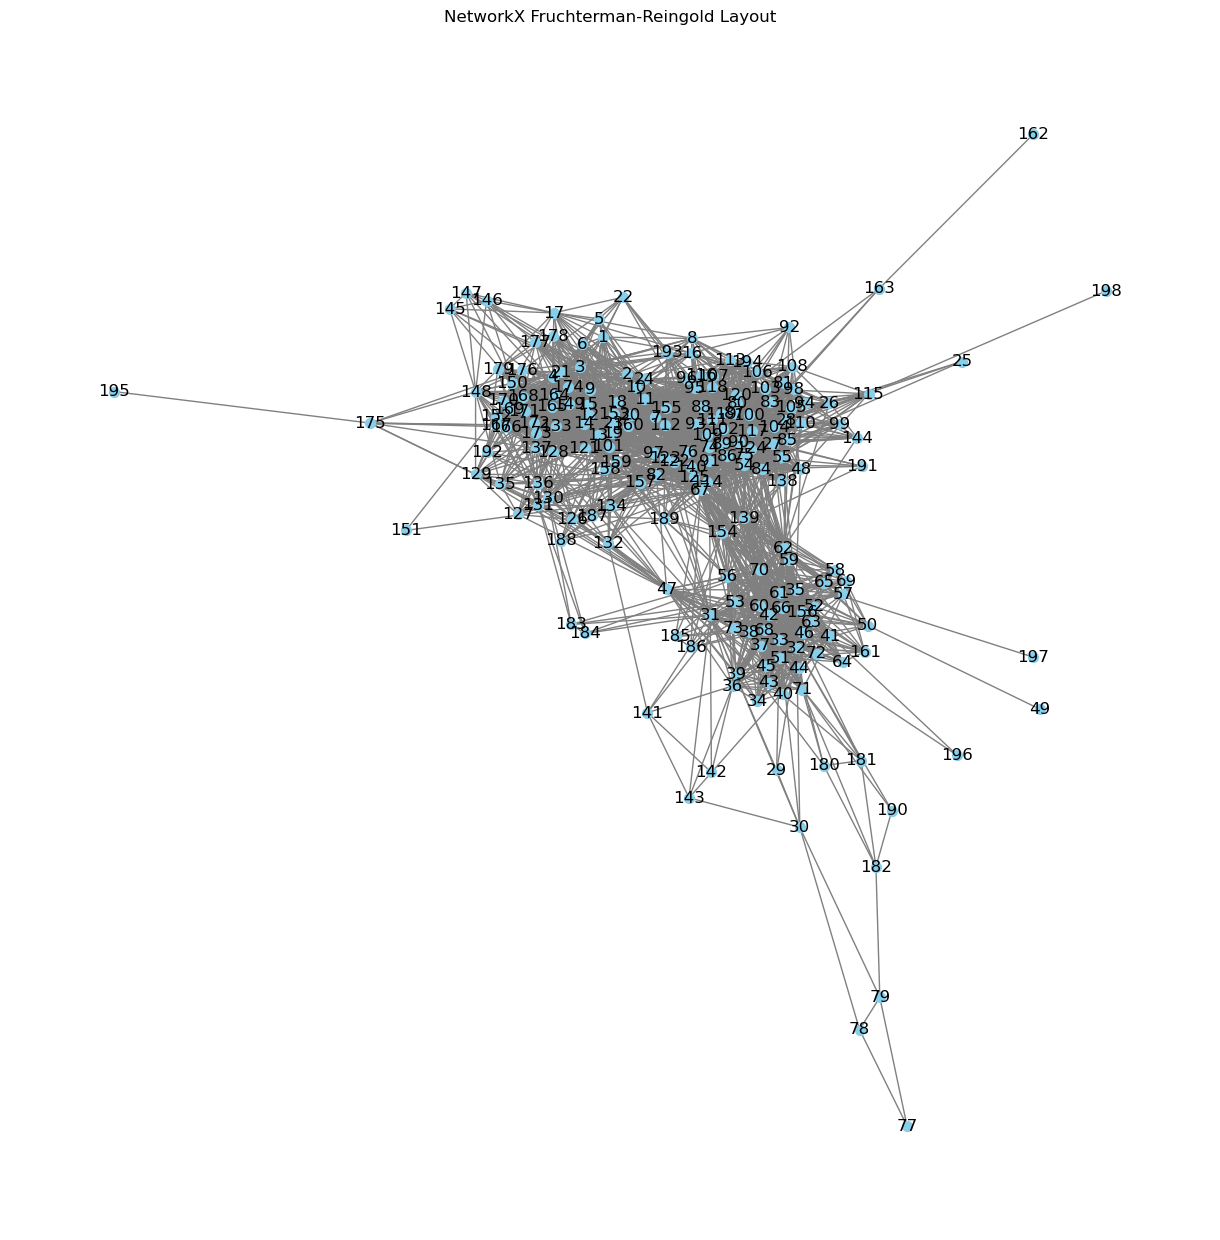

In [25]:
Graph = nx.nx_agraph.read_dot('./Dataset/JazzNetwork.dot/JazzNetwork.dot')

fr_layout = nx.fruchterman_reingold_layout(Graph, iterations=500)

plt.figure(figsize=(12, 12))
nx.draw(Graph, fr_layout, with_labels=True, node_color='skyblue', node_size=50, edge_color='gray')
plt.title('NetworkX Fruchterman-Reingold Layout')
plt.show()

# Fruchterman & Reingold Layout

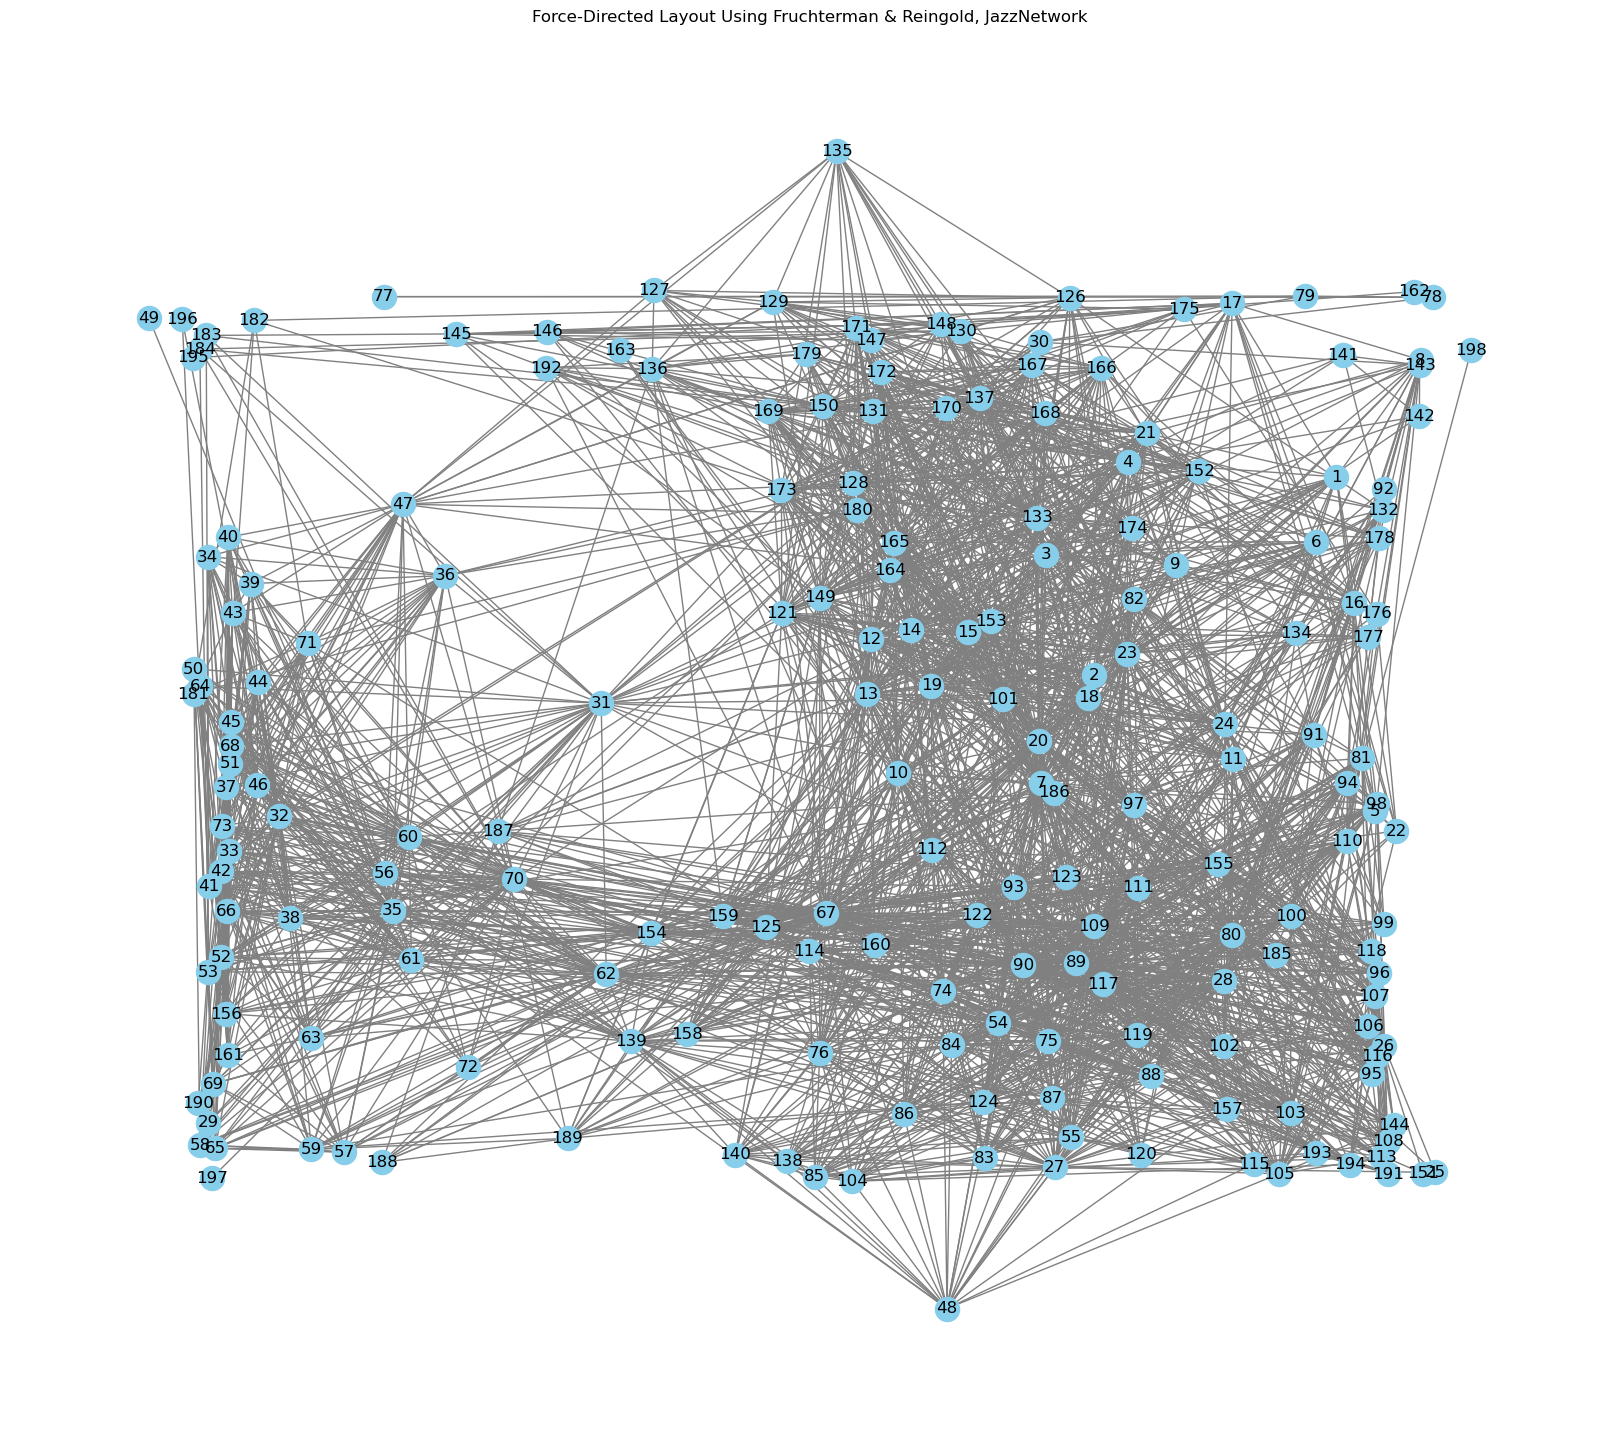

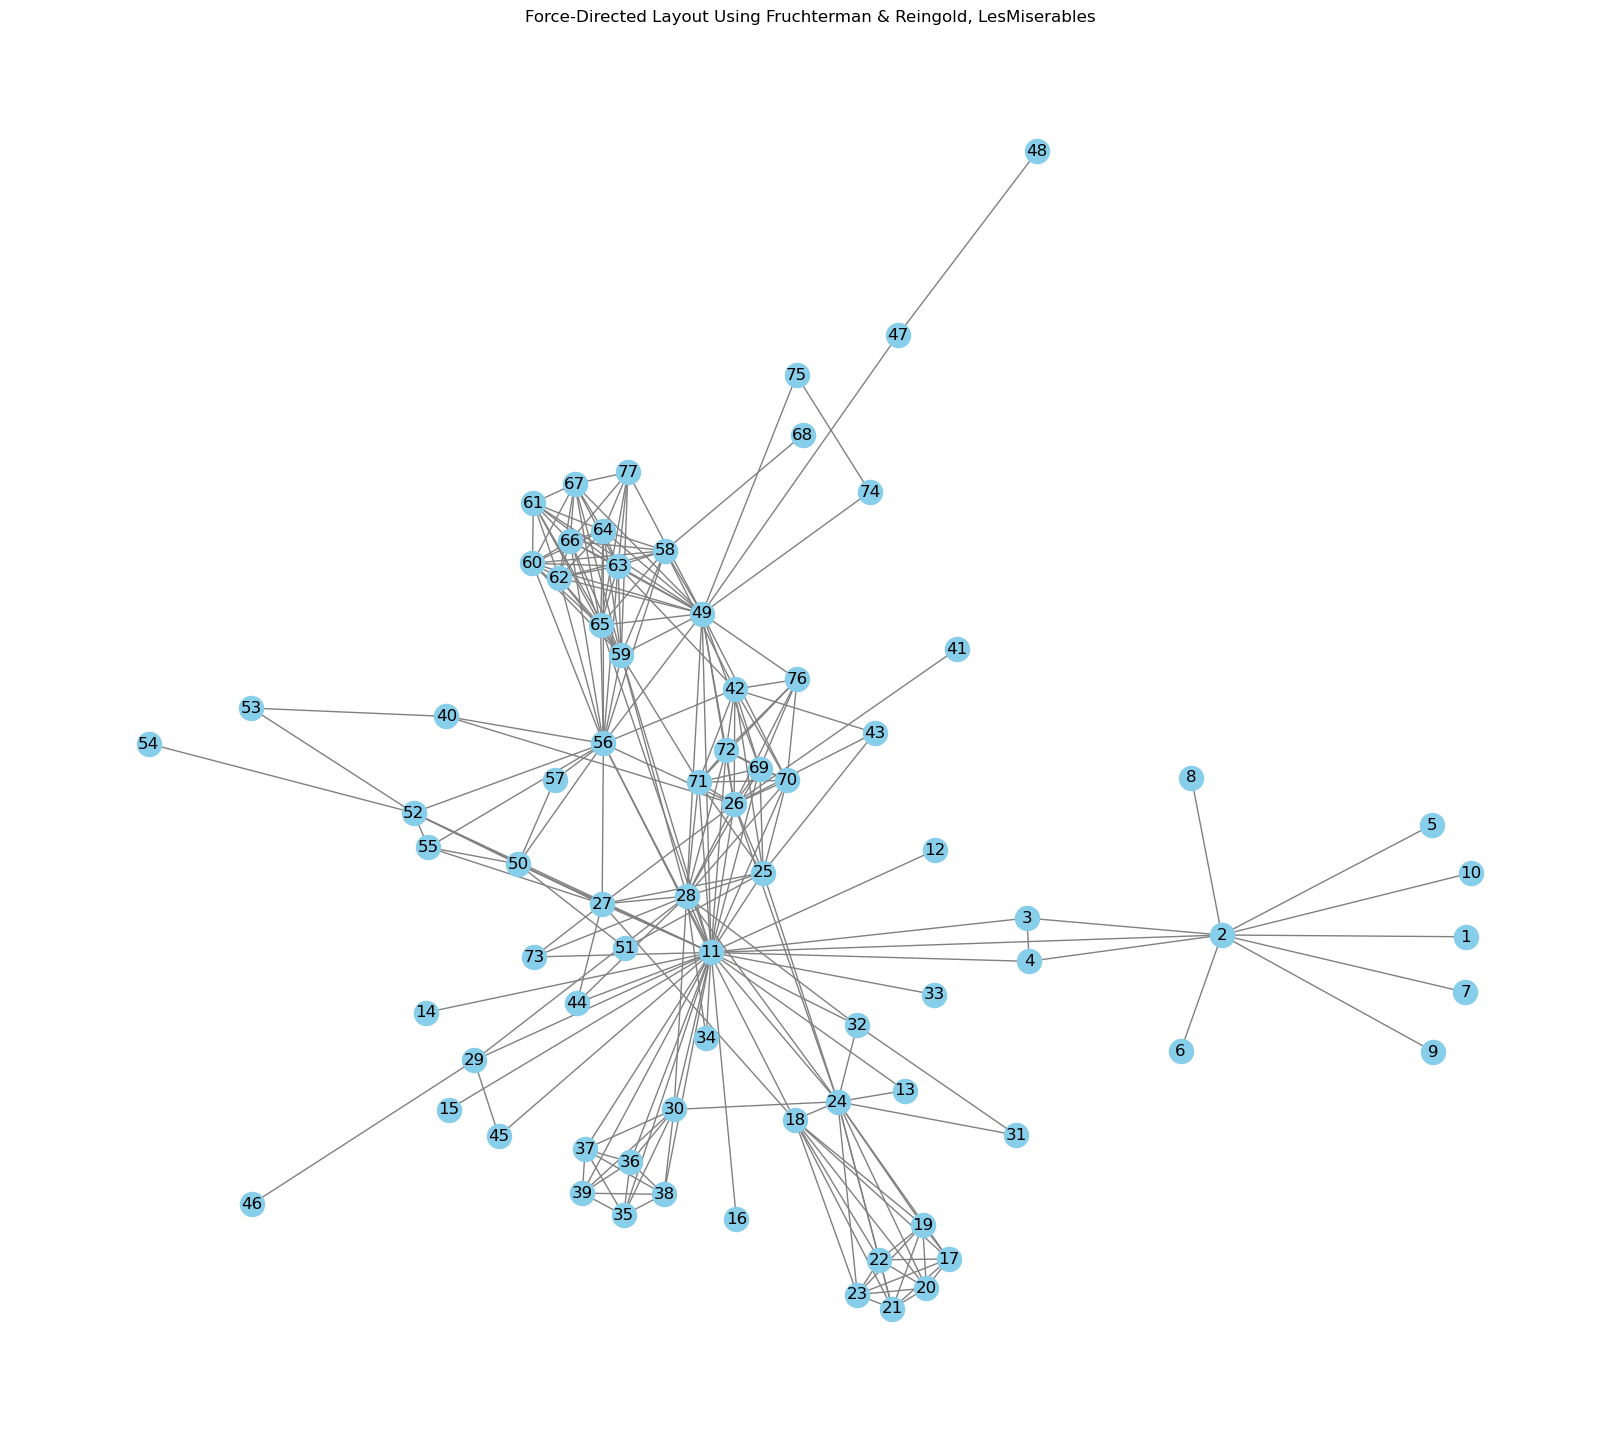

In [15]:
def repulsive_forces_1(G, ideal_edge_length):  
    forces = {node: np.array([0.0, 0.0]) for node in G.nodes()}
    for u in G.nodes():
        for v in G.nodes():
            if u != v:  # Exclude self-repulsion
                delta = np.array(G.nodes[u]['pos']) - np.array(G.nodes[v]['pos'])
                distance = np.linalg.norm(delta) + 1e-6  # Prevent division by zero
                repulsive_force = ideal_edge_length**2 / distance
                forces[u] += repulsive_force * (delta / distance)
    return forces

def attractive_forces_1(G, ideal_edge_length): 
    forces = {node: np.array([0.0, 0.0]) for node in G.nodes()}
    for u, v in G.edges():  # Only iterate over edges
        delta = np.array(G.nodes[v]['pos']) - np.array(G.nodes[u]['pos'])  
        distance = np.linalg.norm(delta) + 1e-6  # Prevent division by zero
        spring_force_magnitude = distance**2 / ideal_edge_length
        forces[u] += spring_force_magnitude * (delta / distance)
        forces[v] -= spring_force_magnitude * (delta / distance)  # Apply equal and opposite force
    return forces

def calculate_spring_forces(G, rep_forces, attr_forces):
    spring_forces = {node: rep_forces[node] for node in G.nodes()}
    for u, v in G.edges():
        spring_forces[u] += attr_forces[u]
        spring_forces[v] += attr_forces[v]
    return spring_forces
import numpy as np

def spring_embedder_f(G, ideal_length, K, epsilon, delta):
    
    for node in G.nodes():
        if 'pos' not in G.nodes[node]:
            G.nodes[node]['pos'] = np.random.rand(2)

    t = 0
    cooling_factor = 0.95  
    min_delta = 0.00001  

    while t < K:
        rep_forces = repulsive_forces_1(G, ideal_length)
        attr_forces = attractive_forces_1(G, ideal_length)
        
        
        for node in G.nodes():
            net_force = rep_forces[node] + attr_forces[node]
            
            displacement = np.clip(delta * net_force, -delta, delta)
            G.nodes[node]['pos'] += displacement

        delta = max(min_delta, cooling_factor * delta)

        max_force = max(np.linalg.norm(G.nodes[node]['pos']) for node in G.nodes())
        if max_force < epsilon:
            break

        t += 1

    return {node: G.nodes[node]['pos'] for node in G.nodes()}

C = 0.1  
area = 100000000  

num_nodes = len(Graph.nodes())
ideal_length = C * (area / num_nodes)**0.5

K = 100  
epsilon = 1e-4  
delta = ideal_length / 10  

position_0 = spring_embedder_f(Graph, ideal_length, K, epsilon, delta)

plt.figure(figsize=(16, 14))
nx.draw(Graph, position_0, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray')
plt.title('Force-Directed Layout Using Fruchterman & Reingold, JazzNetwork')
plt.show()

###################################### LesMiserables  ##########################
C = 0.1  
area = 1000000  

num_nodes = len(Graph_1.nodes())
ideal_length = C * (area / num_nodes)**0.5

K = 100  
epsilon = 1e-4  
delta = ideal_length / 10  
 
position_1 = spring_embedder_f(Graph_1, ideal_length, K, epsilon, delta)

plt.figure(figsize=(16, 14))
nx.draw(Graph_1, position_1, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray')
plt.title('Force-Directed Layout Using Fruchterman & Reingold, LesMiserables')
plt.show()

# address the comment of Tamara

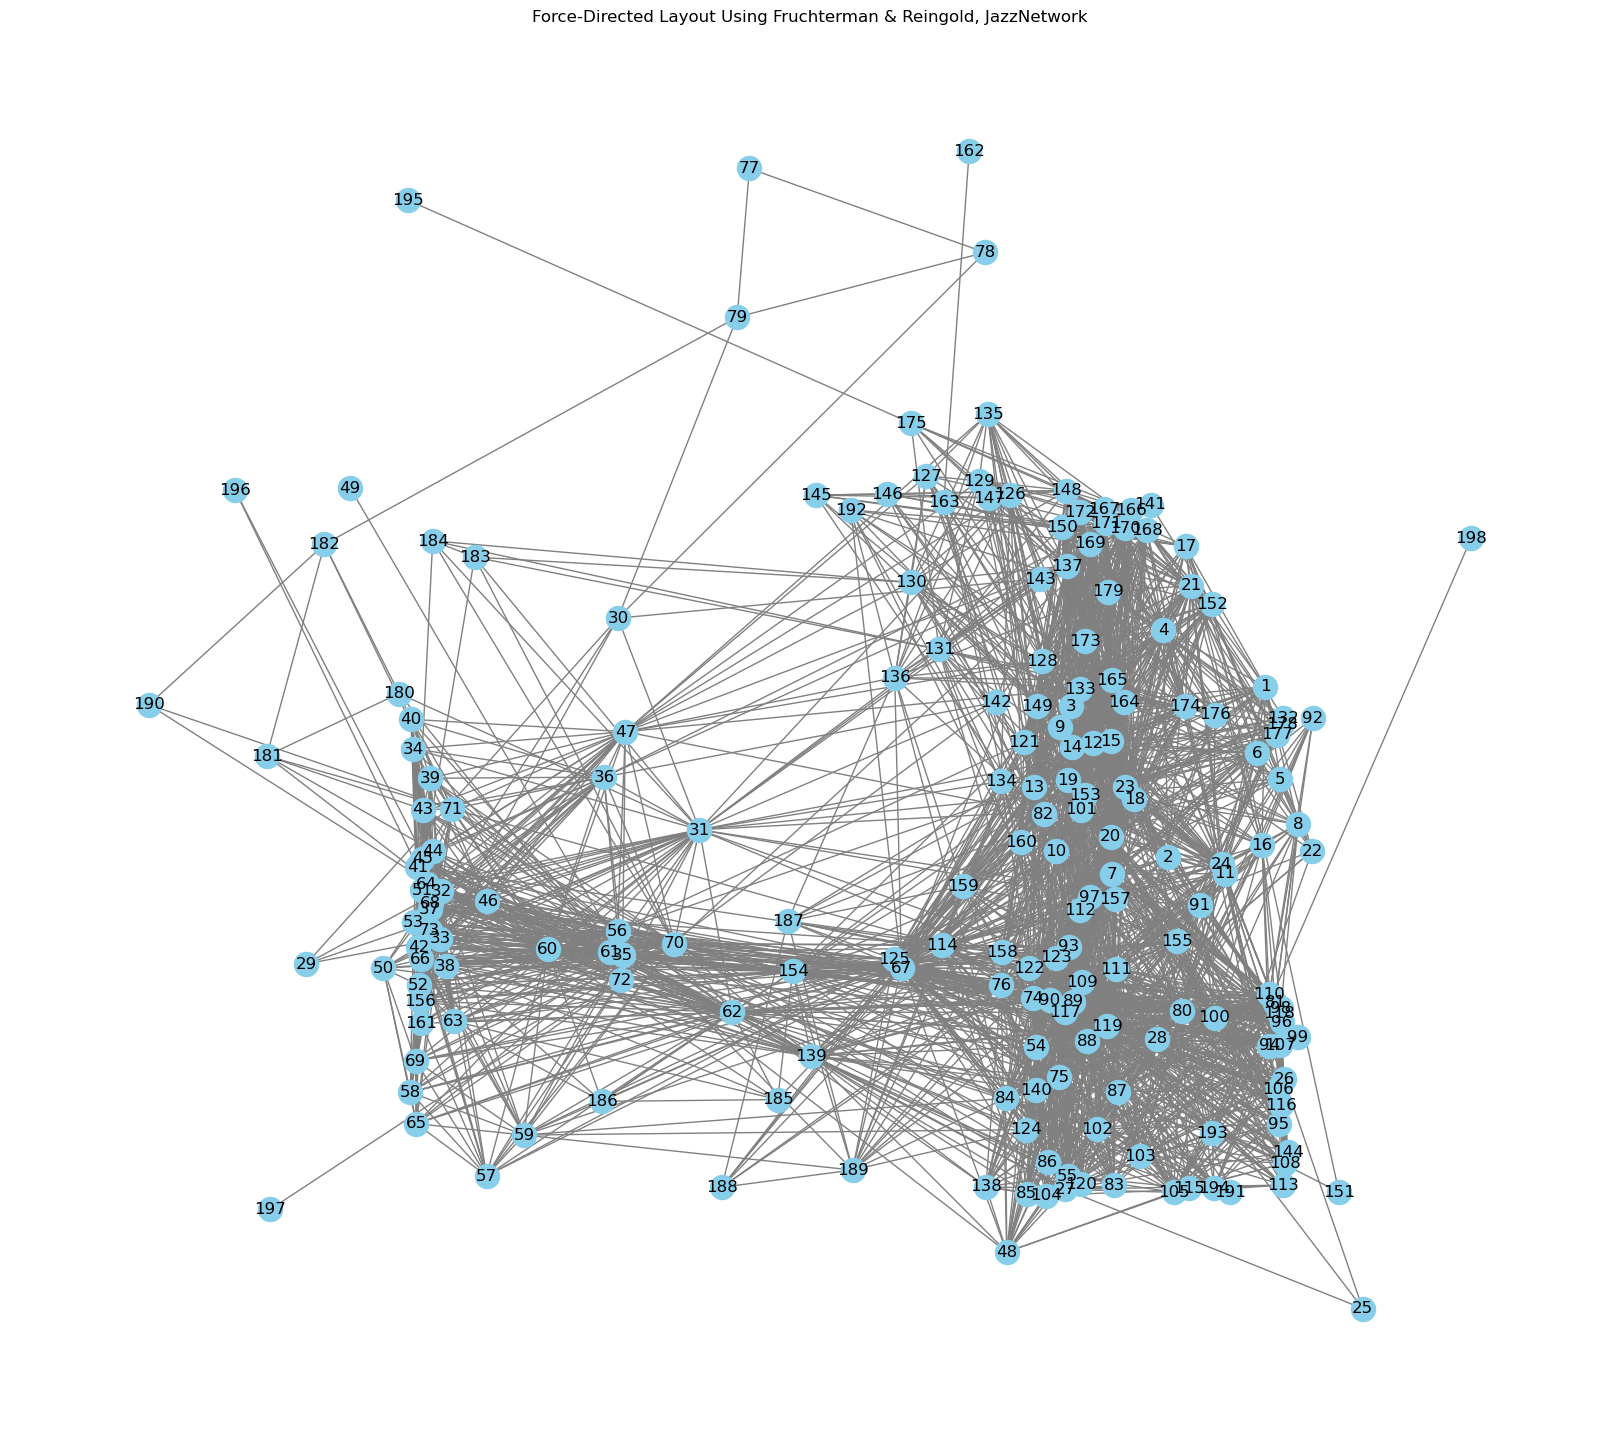

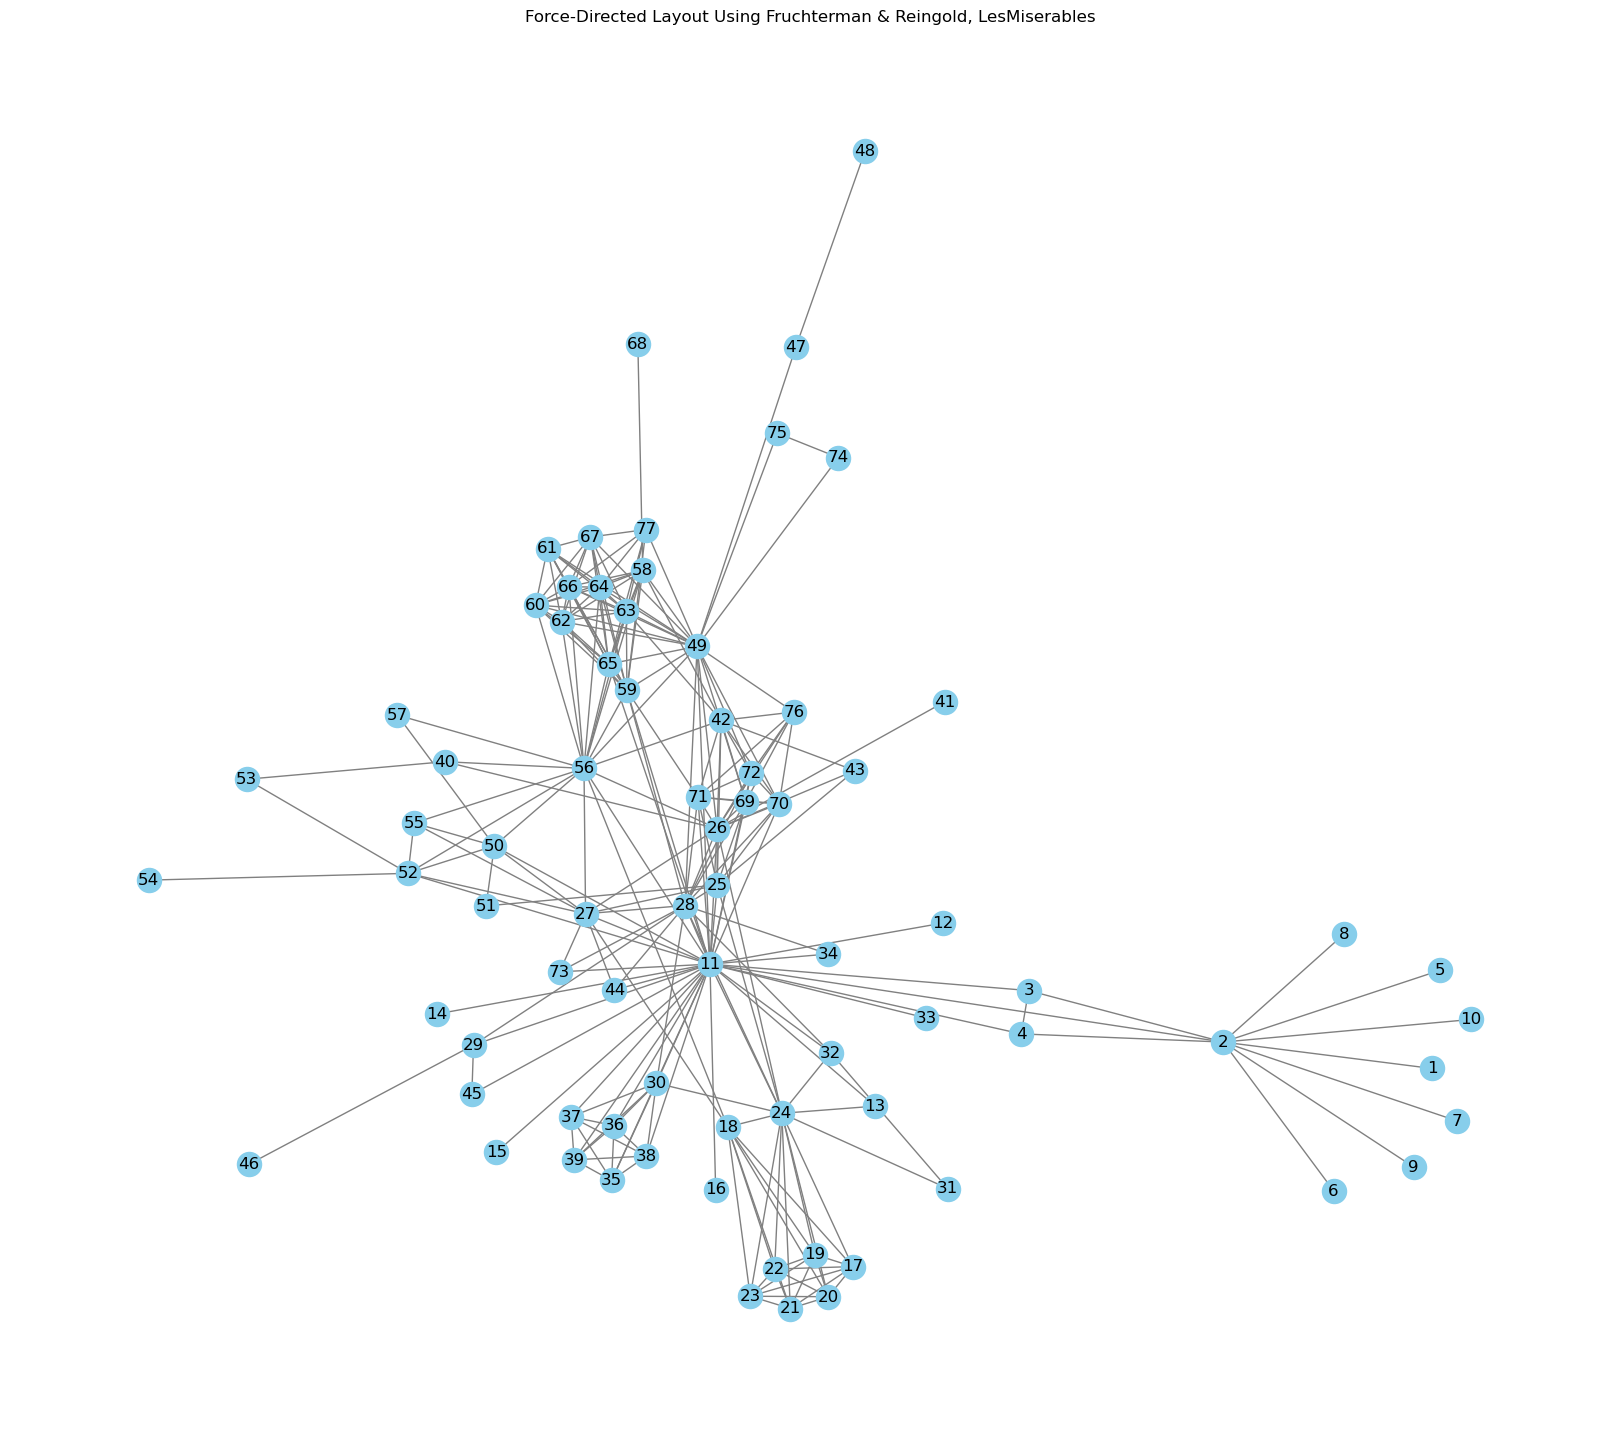

In [18]:
def repulsive_forces_1(G, ideal_edge_length):  
    forces = {node: np.array([0.0, 0.0]) for node in G.nodes()}
    for u in G.nodes():
        for v in G.nodes():
            if u != v:  # Exclude self-repulsion
                delta = np.array(G.nodes[u]['pos']) - np.array(G.nodes[v]['pos'])
                distance = np.linalg.norm(delta) + 1e-6  # Prevent division by zero
                repulsive_force = ideal_edge_length**2 / distance
                forces[u] += repulsive_force * (delta / distance)
    return forces

def attractive_forces_1(G, ideal_edge_length): 
    forces = {node: np.array([0.0, 0.0]) for node in G.nodes()}
    
    for u, v in G.edges():  
        delta = np.array(G.nodes[v]['pos']) - np.array(G.nodes[u]['pos'])  
        distance = np.linalg.norm(delta) + 1e-6 
        spring_force_magnitude = distance**2 / ideal_edge_length
        # Feedback: Instead of updating the forces array, store the force in a separate variable
        force = spring_force_magnitude * (delta / distance) 
        forces[u] += force
        forces[v] -= force  
    
    return forces

def calculate_spring_forces(G, rep_forces, attr_forces):
    spring_forces = {node: rep_forces[node] for node in G.nodes()}
    for u, v in G.edges():
        spring_forces[u] += attr_forces[u]
        spring_forces[v] += attr_forces[v]
    return spring_forces
import numpy as np

def spring_embedder_f(G, ideal_length, K, epsilon, delta):
    
    for node in G.nodes():
        if 'pos' not in G.nodes[node]:
            G.nodes[node]['pos'] = np.random.rand(2)

    t = 0
    cooling_factor = 0.95  
    min_delta = 0.00001  

    while t < K:
        rep_forces = repulsive_forces_1(G, ideal_length)
        attr_forces = attractive_forces_1(G, ideal_length)
        
        
        for node in G.nodes():
            net_force = rep_forces[node] + attr_forces[node]
            
            displacement = np.clip(delta * net_force, -delta, delta)
            G.nodes[node]['pos'] += displacement

        delta = max(min_delta, cooling_factor * delta)

        max_force = max(np.linalg.norm(G.nodes[node]['pos']) for node in G.nodes())
        if max_force < epsilon:
            break

        t += 1

    return {node: G.nodes[node]['pos'] for node in G.nodes()}

C = 0.1  
area = 100000000  

num_nodes = len(Graph.nodes())
ideal_length = C * (area / num_nodes)**0.5

K = 100  
epsilon = 1e-4  
delta = ideal_length / 10  

position_0 = spring_embedder_f(Graph, ideal_length, K, epsilon, delta)

plt.figure(figsize=(16, 14))
nx.draw(Graph, position_0, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray')
plt.title('Force-Directed Layout Using Fruchterman & Reingold, JazzNetwork')
plt.show()

###################################### LesMiserables  ##########################
C = 0.1  
area = 1000000  

num_nodes = len(Graph_1.nodes())
ideal_length = C * (area / num_nodes)**0.5

K = 100  
epsilon = 1e-4  
delta = ideal_length / 10  
 
position_1 = spring_embedder_f(Graph_1, ideal_length, K, epsilon, delta)

plt.figure(figsize=(16, 14))
nx.draw(Graph_1, position_1, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray')
plt.title('Force-Directed Layout Using Fruchterman & Reingold, LesMiserables')
plt.show()

# Modification (using mass + gravity + magnetic)

### Gravitational attraction is a modification  to the algorithm that pulls nodes towards the center of the layout, preventing them from  "floating away" into space

### Magnetic forces are used to align edges in a preferred direction (vertically or horizontally), which can enhance the visual appeal and readability of the graph by reducing edge crossings or making the layout more structured.

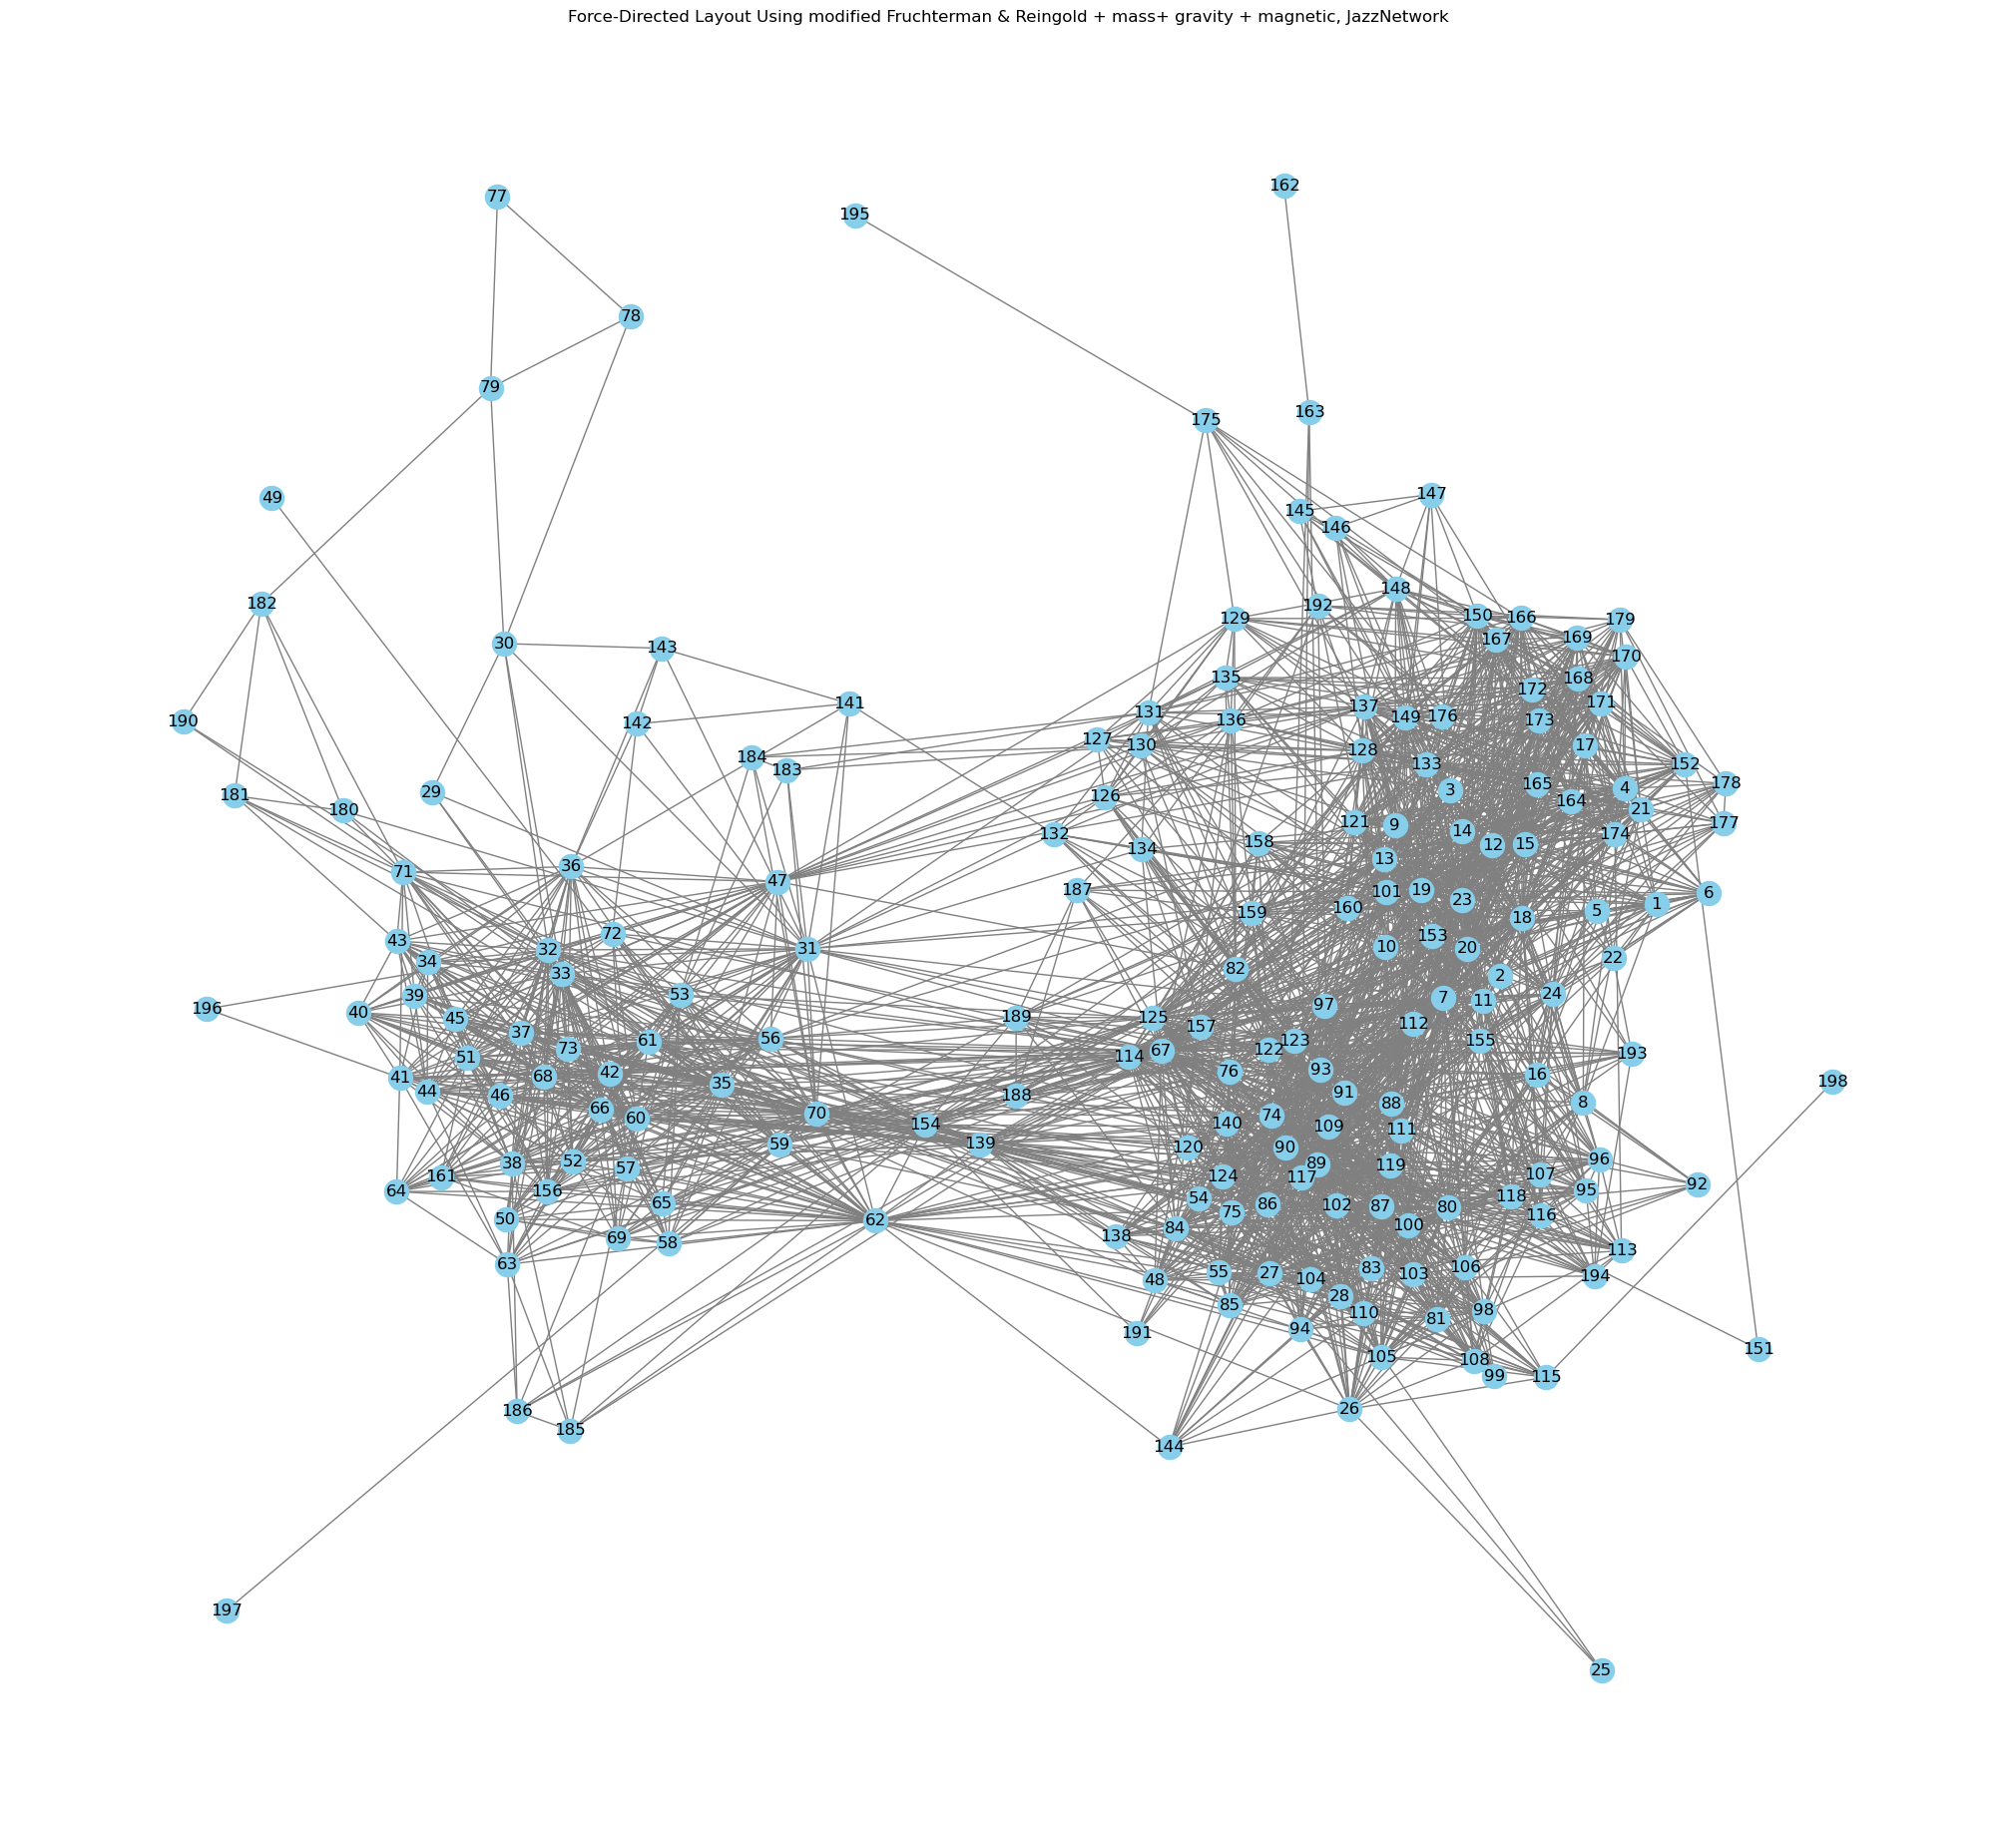

In [23]:
def magnetic_forces(G, magnetic_constant):
    forces = {node: np.array([0.0, 0.0]) for node in G.nodes()}
    field_direction = np.array([0, 1])  # use [1, 0] for a horizontal field

    for u, v in G.edges():
        delta = np.array(G.nodes[v]['pos']) - np.array(G.nodes[u]['pos'])
        edge_direction = delta / (np.linalg.norm(delta) + 1e-6)
        cos_theta = np.dot(edge_direction, field_direction)
        angle = np.arccos(np.clip(cos_theta, -1, 1))  
        magnetic_force_magnitude = magnetic_constant * (1 - cos_theta)
        # Calculate perpendicular direction to the edge direction to apply force
        perpendicular_dir = np.array([-edge_direction[1], edge_direction[0]])
        magnetic_force = magnetic_force_magnitude * perpendicular_dir
        
        forces[u] += magnetic_force
        forces[v] -= magnetic_force
    return forces



def gravitational_forces(G, center_point, gravitational_constant):
    forces = {node: np.array([0.0, 0.0]) for node in G.nodes()}
    for node in G.nodes():
        delta = center_point - np.array(G.nodes[node]['pos'])
        
        distance = np.linalg.norm(delta)
        grav_force = gravitational_constant * delta
        forces[node] += grav_force / distance if distance > 0 else 0
    return forces


def repulsive_forces_1(G, ideal_edge_length):  
    forces = {node: np.array([0.0, 0.0]) for node in G.nodes()}
    for u in G.nodes():
        for v in G.nodes():
            if u != v:  
                delta = np.array(G.nodes[u]['pos']) - np.array(G.nodes[v]['pos'])
                distance = np.linalg.norm(delta) + 1e-6  
                repulsive_force = ideal_edge_length**2 / distance
                forces[u] += repulsive_force * (delta / distance)
    return forces

def modified_attractive_forces_1(G, ideal_edge_length): 
    forces = {node: np.array([0.0, 0.0]) for node in G.nodes()}
    
    mass = {node: 1 + G.degree(node) / 2 for node in G.nodes()}  # Calculate node mass**1
    
    for u, v in G.edges():  
        delta = np.array(G.nodes[v]['pos']) - np.array(G.nodes[u]['pos'])  
        distance = np.linalg.norm(delta) + 1e-6 
        spring_force_magnitude = (distance**2 / ideal_edge_length) / mass[u]  # Divide by mass of node u
        forces[u] += spring_force_magnitude * (delta / distance)
        forces[v] -= spring_force_magnitude * (delta / distance)  # Apply equal and opposite force
    return forces

def calculate_spring_forces(G, rep_forces, attr_forces):
    spring_forces = {node: rep_forces[node] for node in G.nodes()}
    for u, v in G.edges():
        spring_forces[u] += attr_forces[u]
        spring_forces[v] += attr_forces[v]
    return spring_forces
import numpy as np

def spring_embedder_f(G, ideal_length, K, epsilon, delta, gravitational_constant, magnetic_constant):
    center_point = np.array([0.5, 0.5])  # Assuming center of graph is at (0.5, 0.5)
    
    for node in G.nodes():
        if 'pos' not in G.nodes[node]:
            G.nodes[node]['pos'] = np.random.rand(2)

    t = 0
    cooling_factor = 0.95  
    min_delta = 0.00001  

    while t < K:
        rep_forces = repulsive_forces_1(G, ideal_length)
        attr_forces = modified_attractive_forces_1(G, ideal_length) #we used the modified forces here
        grav_forces = gravitational_forces(G, center_point, gravitational_constant) #Gravity
        mag_forces = magnetic_forces(G, magnetic_constant)  #magnetic 
        
        for node in G.nodes():
            net_force = rep_forces[node] + attr_forces[node] + grav_forces[node] + mag_forces[node] #+gravity/magnetic
            displacement = np.clip(delta * net_force, -delta, delta)
            G.nodes[node]['pos'] += displacement

        delta = max(min_delta, cooling_factor * delta)

        max_force = max(np.linalg.norm(G.nodes[node]['pos']) for node in G.nodes())
        if max_force < epsilon:
            break

        t += 1

    return {node: G.nodes[node]['pos'] for node in G.nodes()}


C = 0.1  
area = 100000000  

num_nodes = len(Graph.nodes())
ideal_length = C * (area / num_nodes)**0.5

K = 100  
epsilon = 1e-4  
delta = ideal_length / 10  

gravitational_constant = 0.001 * ideal_length
magnetic_constant = 0.2

position_0 = spring_embedder_f(Graph, ideal_length, K, epsilon, delta, gravitational_constant, magnetic_constant)

plt.figure(figsize=(20, 18))
nx.draw(Graph, position_0, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray')
plt.title('Force-Directed Layout Using modified Fruchterman & Reingold + mass+ gravity + magnetic, JazzNetwork')
plt.show()